# Script Prep.

In [21]:
from google.colab import drive
drive.mount('/content/drive/')

import sys
sys.path.append('/content/drive/Shareddrives/NUTRECON/1. Acquisition/current_version/notebooks')

from nutrecon import *

import numpy as np
from glob import glob
from datetime import datetime
import json

from random import shuffle, sample
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns

experiment_code = 'nutre'
dataPath = root[:-1] + "2. Data/raw/nutrecon/"
sequences_dataPath = dataPath + 'sequences/'
responses_dataPath = dataPath + 'responses/'

pres_order_d2_fileID = 'day2_presOrder'
assoc2_order_fileID = 'day2_atestOrder'
neuroEcon_responses_fileID = 'day2_neuroEcon'

flavorName_colName = 'Flavor'
pres_order_colName = 'Presentation Order'

neurEconRealization2_fileID = 'day2_neurEconRealization'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# 1. Flavor tasting order 

In [22]:
subject_nr = 3    # Change subject number here

# ==============================================================================

subject_code = '{}{:03d}'.format(experiment_code, subject_nr)
presentation_order_d2_df, _ = loadResponses(sequences_dataPath, pres_order_d2_fileID, subject_code)
presentation_order_d2_df.T

,Flavor,image,flavor_id,image_id
0,ginseng,cross,i,Image VI
1,cashew,square,c,Image I


## 1.1 Check ratings

In [23]:
df_, _ = loadResponses(responses_dataPath, flav_ratings_fileID, subject_code)
df_

,Day,Trial,User,intensity,intensity_timestamp,novelty,novelty_timestamp,pleasantness,pleasantness_timestamp
0,1,1,nutre003,9,1670496103,29,1670496086,3,1670496117
1,1,2,nutre003,24,1670496166,26,1670496158,-4,1670496175
2,1,3,nutre003,19,1670496222,70,1670496213,-10,1670496234
3,1,4,nutre003,31,1670496271,5,1670496264,-28,1670496278
4,1,5,nutre003,14,1670496318,35,1670496313,11,1670496325
5,1,6,nutre003,14,1670496366,18,1670496357,32,1670496374
6,1,7,nutre003,30,1670496412,55,1670496406,38,1670496420
7,1,8,nutre003,25,1670496452,11,1670496447,19,1670496458


In [24]:
presentation_order_d2_df.T.reset_index()

,index,Flavor,image,flavor_id,image_id
0,0,ginseng,cross,i,Image VI
1,1,cashew,square,c,Image I


In [19]:
flav_ratings_fileID = 'day2_rating'

intensity_colName = 'intensity'
novelty_colName = 'novelty'
pleasanteness_colName = 'pleasantness'
pres_order_colName = 'index'

pleas_min = 0
pleas_max = 80
df_pleas = None
df_pleas_ = None

ratings_colNames = ['User','Trial',novelty_colName, intensity_colName, pleasanteness_colName]
df_, _ = loadResponses(responses_dataPath, flav_ratings_fileID, subject_code)
if not df_ is None:

  df = presentation_order_d2_df.T.reset_index().merge(df_[ratings_colNames],
                                  left_on = pres_order_colName, right_on = 'Trial').drop(columns='Trial')
  df_pleas = df[(df[pleasanteness_colName] >= pleas_min) & (df[pleasanteness_colName] < pleas_max)].sort_values(by=novelty_colName, ascending = False)
  if len(df_pleas) == 0 :
    df_pleas = df.sort_values(by=[pleasanteness_colName, novelty_colName], key=abs).set_index(np.arange(1,len(df)+1))
    df_pleas['criteria'] = 'not in complience'
  else:
    df_pleas['criteria'] = 'in complience'
    flavors_ = df_pleas[flavorName_colName].to_list()
    df_ = df[~df[flavorName_colName].isin(flavors_)].sort_values(by=[pleasanteness_colName, novelty_colName], key=abs)
    df_['criteria'] = 'not in complience'
    df_pleas = pd.concat([df_pleas, df_])
  df_pleas = df_pleas.set_index(np.arange(len(df_pleas)) + 1).rename_axis('').reset_index().set_index(['criteria', ''])
  df_pleas_ = df_pleas.drop(columns = ['User',pres_order_colName] )

df_pleas_

No file found for this subject.


# 2. Association test order  (day 2)

In [25]:
associationTest2_df, _ = loadResponses(sequences_dataPath, assoc2_order_fileID, subject_code)
associationTest2_df.T

,Flavor,image,flavor_id,image_id
1,cashew,square,c,Image I
2,ginseng,cross,i,Image VI
3,cashew,square,c,Image I
4,cashew,square,c,Image I
5,ginseng,cross,i,Image VI
6,cashew,square,c,Image I
7,ginseng,cross,i,Image VI
8,cashew,square,c,Image I
9,cashew,square,c,Image I
10,cashew,square,c,Image I


			Accuracy: 1.0


precision  recall  f1-score   Flavor
criteria      image_id flavor_id                                      
in compliance Image I  c                1.0     1.0       1.0   cashew
              Image VI i                1.0     1.0       1.0  ginseng

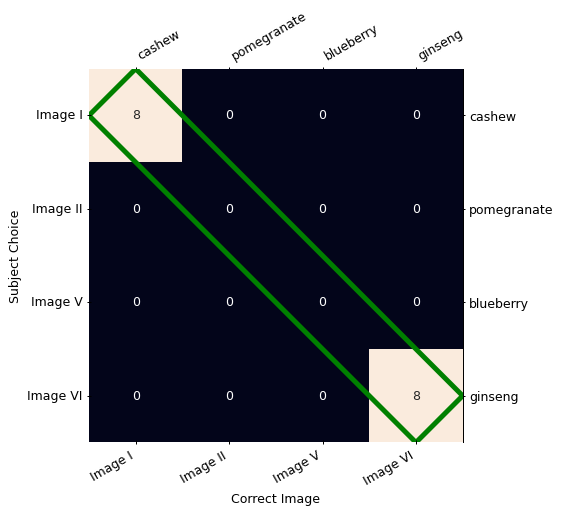

In [26]:
flavorCodes = {
    'blueberry' : 'g',
    'cashew' : 'c', 
    'dragon fruit': 'h',
    'ginseng' : 'i',
    'grapefruit': 'j',
    'licorice': 'k',
    'lychee': 'd', 
    'pomegranate': 'e' 
  }

imageCodes = {
    'Image I' : 'square',
    'Image II' : 'hexagon',
    'Image V' : 'circle',
    'Image VI' : 'cross'}

imageDecoder = {0: 'Image I',
                1: 'Image II',
                #2: 'Image III',
                #3: 'Image IV',
                4: 'Image V',
                5: 'Image VI'
                }

learn_order_fileID = 'day1_learnOrder'
imageID_colName = 'image_id'


min_correctResp = 4
imageFlavor_df, _ = loadResponses(sequences_dataPath, learn_order_fileID, subject_code)
flavorImage_code = {p[imageID_colName]:p[flavorName_colName] for p in imageFlavor_df.T[[imageID_colName, flavorName_colName]].to_dict('index').values()}
atest_day2_sequence = [get_key(imageDecoder,p) for p in associationTest2_df.T['image_id'].tolist()]
atest_day2_responses, _ = loadResponses(responses_dataPath, 'day2_atest', subject_code)

fig, report = reportAndConfusionMatrix(atest_day2_sequence, atest_day2_responses['image_id'].tolist(), flavorImage_code)
fig.savefig('atest2.png')
check_atest(report, flavorImage_code, min_correctResp)

# 3. Reward realization (day 2)

In [27]:
df, responses_path = loadResponses(responses_dataPath, neuroEcon_responses_fileID, subject_code)

seed = int(responses_path.split('_')[-1].split('.')[0])
rng = np.random.default_rng(int(responses_path.split('_')[-1].split('.')[0]))

df_clean = df[df['choice'] != 0]

mix_yogurt_df = df_clean[df_clean['Trial Type'] == 'mixed_yogurt']
st_mt_df = df_clean[df_clean['Trial Type'] != 'mixed_yogurt']

realizationTrials_df  = pd.concat([mix_yogurt_df.sample(1), st_mt_df.groupby(['Trial Type', 'lottery type']).sample(1)]).reset_index(drop = True)

realizationResults_df = realizationTrials_df.apply(lambda row: realizeChoices(row,rng), axis = 1)
realizationResults_df = save_json(realizationResults_df, subject_code, neurEconRealization2_fileID , sequences_dataPath)
realizationResults_df[['Trial Type', 'reference type', 'lottery type', 'reference qt', 'lottery qt', 'reference p', 'lottery p', 'choice', 'reward Qt.',	'reward description']]

,Trial Type,reference type,lottery type,reference qt,lottery qt,reference p,lottery p,choice,reward Qt.,reward description
0,mixed_yogurt,C+,C-,40.0,120,0.75,0.13,1,40.0,mL of ginseng yogurt
1,mixed,money,C+,0.2,200,1.00,0.13,2,0.0,You got nothing
2,mixed,money,C-,0.2,80,1.00,0.22,2,0.0,You got nothing
3,same,C+,C+,20.0,20,1.00,0.22,1,20.0,mL of ginseng yogurt
4,same,C-,C-,20.0,40,1.00,0.75,1,20.0,mL of cashew yogurt
5,same,money,money,1.0,2,1.00,0.13,1,1.0,€
